# Learning To Rank Currency Investments

## 1 Generate Time Series Data

Data Feeding for Training (and Updating) based on [Python YFinance API](https://github.com/ranaroussi/yfinance). Complete

In [2]:
# Cloud/Local Env Handling
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

Mounted at /content/drive


In [3]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import pandas as pd
import yfinance as yf
import riskfolio.RiskFunctions as rf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import gc

# Custom Handmade Modules (please copy folder to Colab Notebooks root)
from modules import performance_measures_helper as pms
import importlib # for continuous reloading

# For Ratios with Extreme Values
from scipy.stats.mstats import winsorize

# For Serializing
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
INCEPTION_DATE = "1998-1-02" # CONSTANT
CUT_DATE = "2022-09-30"      # OTHER CONSTANT (consider to move to a module)

CURRENCIES = [
    "EURUSD=X", "EURJPY=X", "EURGBP=X", 		    		
    "EURCAD=X",	"EURAUD=X",	"EURNZD=X",		
    "EURDKK=X",	"EURNOK=X",	"EURSEK=X",
    "EURCHF=X"
]

In [ ]:
data = yf.download(
    CURRENCIES,
    INCEPTION_DATE,
    CUT_DATE
)["Close"]

data.head()
# Insert Here a Adjusting Layer (Open, High, Low, ...) for taking into account Corporate Events

[*********************100%***********************]  10 of 10 completed


,EURAUD=X,EURCAD=X,EURCHF=X,EURDKK=X,EURGBP=X,EURJPY=X,EURNOK=X,EURNZD=X,EURSEK=X,EURUSD=X
Date,,,,,,,,,,
1998-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4447,NaN
1998-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4284,NaN
1998-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3853,NaN
1998-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3561,NaN
1998-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3244,NaN


In [ ]:
data.dropna(how="any", inplace=True)

In [ ]:
data.to_csv(PATH + "fx_data/FX_rates.csv")

In [ ]:
inverse_fx_data = 1/data

In [ ]:
# Putting names of currency invested from € investor point of view (G10 Countries)
direct_symbols = inverse_fx_data.columns.tolist()

inverse_symbols = list()
for symbol in direct_symbols:        
    inverse_symbols.append(symbol.replace("EUR","").replace("=X",""))

inverse_fx_data.columns = inverse_symbols
inverse_fx_data.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,0.608532,0.641190,0.644122,0.134412,1.437401,0.007658,0.122489,0.537519,0.110926,0.83577
2003-12-02,0.605877,0.638162,0.642591,0.134382,1.432665,0.007608,0.122496,0.535045,0.111015,0.82720
2003-12-03,0.608236,0.634558,0.641890,0.134387,1.427144,0.007618,0.123183,0.533561,0.111458,0.82488
2003-12-04,0.609310,0.631752,0.642674,0.134401,1.424907,0.007648,0.123704,0.534759,0.111595,0.82775
2003-12-05,0.604522,0.629882,0.644995,0.134400,1.422475,0.007649,0.123724,0.530082,0.111818,0.82055


In [ ]:
inverse_fx_data.to_csv(PATH + "fx_data/inverse_FX_rates.csv")

### Brief Exploration-Graph Analysis (EDA complete delayed)



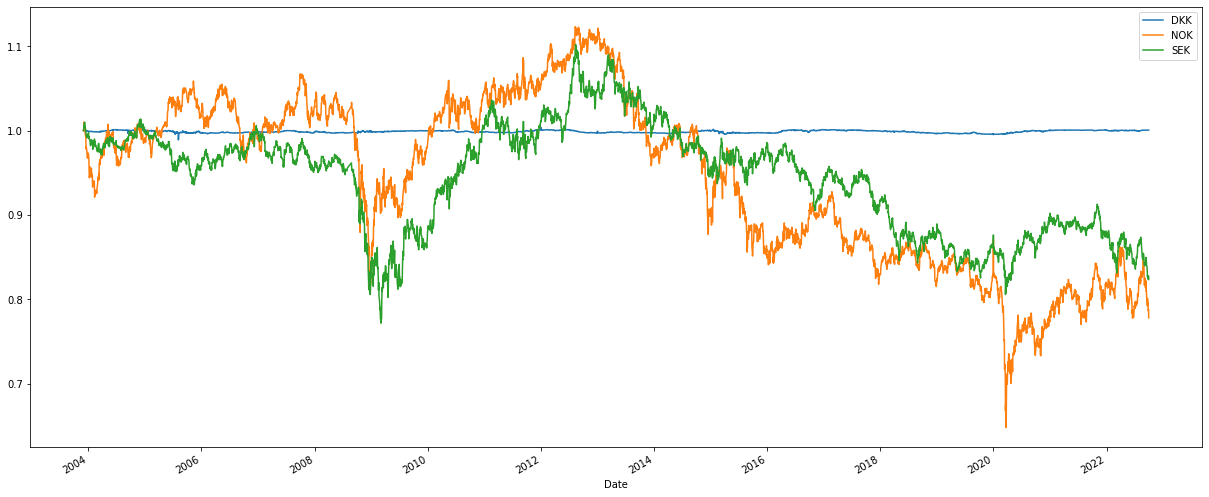

In [ ]:
(inverse_fx_data/inverse_fx_data.iloc[0])[["DKK","NOK","SEK"]].plot(figsize=(21,9)); # DKK: indirect EUR proxy

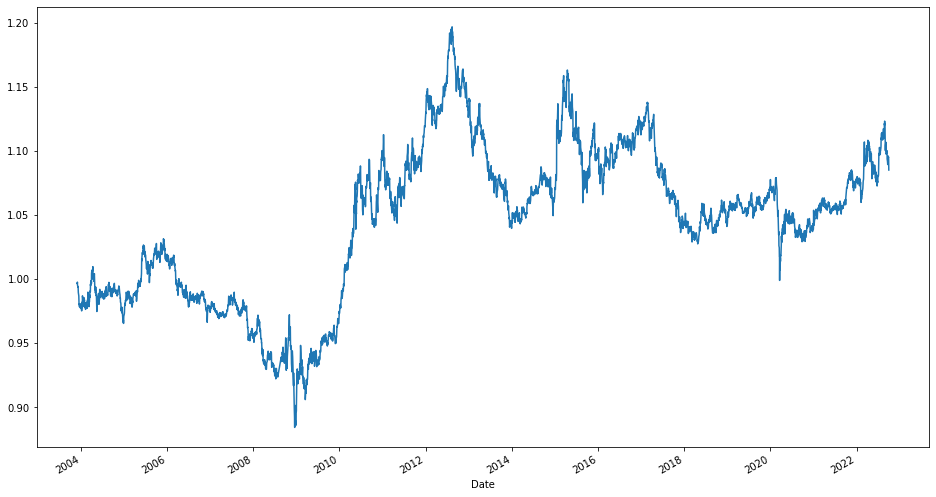

In [ ]:
# Solomonic Portfolio of Currencies
(1+inverse_fx_data.pct_change().mean(axis=1)).cumprod().plot(figsize=(16,9));

## 2 Adding Target (relevances)

Daily relevances based on one-step ahead daily returns

In [ ]:
ratings = inverse_fx_data.pct_change().rank(axis=1).shift(-1)

In [ ]:
ratings

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,5.0,3.0,7.0,8.0,6.0,2.0,9.0,4.0,10.0,1.0
2003-12-02,8.0,1.0,5.0,6.0,2.0,7.0,10.0,4.0,9.0,3.0
2003-12-03,6.0,1.0,4.0,3.0,2.0,9.0,10.0,7.0,5.0,8.0
2003-12-04,3.0,4.0,10.0,6.0,5.0,8.0,7.0,1.0,9.0,2.0
2003-12-05,10.0,9.0,8.0,5.0,4.0,2.0,1.0,6.0,7.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,5.0,4.0,3.0,7.0,8.0,6.0,1.0,2.0,9.0,10.0
2022-09-27,2.0,8.0,10.0,5.0,3.0,6.0,7.0,1.0,4.0,9.0
2022-09-28,6.0,3.0,9.0,7.0,5.0,2.0,4.0,10.0,8.0,1.0


In [ ]:
best_signal = (ratings==10.).shift(1)
worst_signal = (ratings==1.).shift(1)

In [ ]:
best_signal.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,False,False,False,False,False,False,False,False,True,False
2003-12-03,False,False,False,False,False,False,True,False,False,False
2003-12-04,False,False,False,False,False,False,True,False,False,False
2003-12-05,False,False,True,False,False,False,False,False,False,False


In [ ]:
fx_returns_daily = inverse_fx_data.pct_change()
fx_returns_daily.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,-0.004362,-0.004722,-0.002378,-0.000229,-0.003295,-0.006543,0.000061,-0.004601,0.000799,-0.010254
2003-12-03,0.003893,-0.005648,-0.001091,0.000040,-0.003853,0.001371,0.005605,-0.002775,0.003990,-0.002805
2003-12-04,0.001767,-0.004422,0.001221,0.000107,-0.001567,0.003824,0.004231,0.002246,0.001228,0.003479
2003-12-05,-0.007859,-0.002960,0.003612,-0.000013,-0.001707,0.000229,0.000161,-0.008746,0.002002,-0.008698


In [ ]:
fx_returns_daily[best_signal].head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000799,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,0.005605,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,0.004231,NaN,NaN,NaN
2003-12-05,NaN,NaN,0.003612,NaN,NaN,NaN,NaN,NaN,NaN,NaN


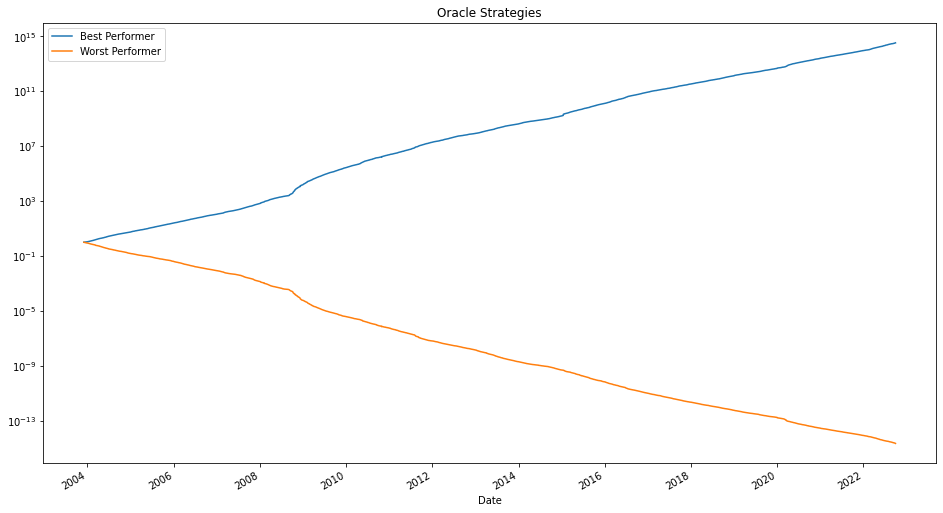

In [ ]:
plot_args = {
    "figsize": (16,9),
    "legend": True
}

(1+fx_returns_daily[best_signal].mean(axis=1,skipna=True)).cumprod().rename("Best Performer").plot(**plot_args, title="Oracle Strategies");
(1+fx_returns_daily[worst_signal].mean(axis=1,skipna=True)).cumprod().rename("Worst Performer").plot(**plot_args);
plt.semilogy();

In [ ]:
score_returns = pd.melt(
    ratings,
    var_name="symbols",
    value_name="score_return",
    ignore_index=False
).reset_index(
).sort_values(by=["Date","symbols"])

In [ ]:
score_returns.dropna(inplace=True)

In [ ]:
score_returns.rename(columns={"score_return": "rank"}, inplace=True)

In [ ]:
score_returns= score_returns.astype({"rank": int})

In [ ]:
score_returns.head()

,Date,symbols,rank
0,2003-12-01,AUD,5
4881,2003-12-01,CAD,3
9762,2003-12-01,CHF,7
14643,2003-12-01,DKK,8
19524,2003-12-01,GBP,6


In [ ]:
score_returns.to_csv(
    PATH + "fx_data/FX_quantized_returns.csv",
    index=False
)

## 3 Return-Based Features

Checkpoint: reset kernel [rerun Jupyter cell](#scrollTo=Fk9Gp-VT1riu&line=10&uniqifier=1) and then continue.

In [ ]:
# Checkpoint: Reset Kernel if needed
plot_args = {
    "figsize": (16,9),
    "legend": True
}

In [ ]:
inverse_fx_rates=pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col = "Date",
    parse_dates = ["Date"]
)

In [ ]:
# Constructing Momentum Features (Raw Cumulative Returns Over Some Past Horizons)
days = [5,10,21,63]
feature_names = ["MOM1W","MOM2W","MOM1M","MOM3M"]
features = dict()

for f, d in zip(feature_names, days):
    features[f] = inverse_fx_rates.pct_change(d)

<AxesSubplot:xlabel='Date'>

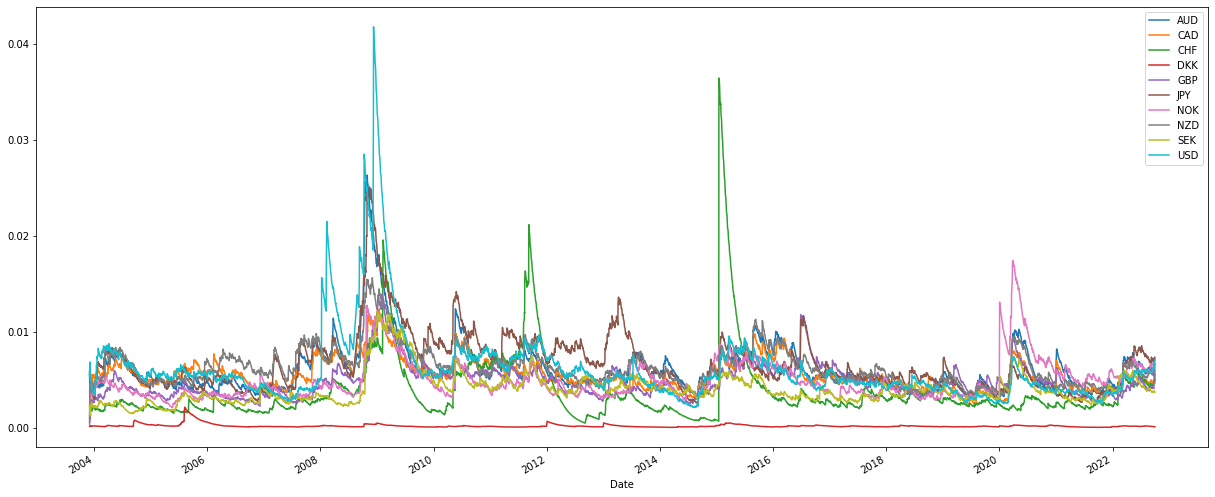

In [ ]:
# 3M EWM Volatility as daily VOL estimator (GARCH estimators can also be used)
inverse_fx_rates.pct_change().ewm(span=63).std().plot(figsize=(21,9))

In [ ]:
# Adding Year-Scaled Daily Volatility Stimator based on 3M EWM Volatility
features["EWVOL3M"] = np.sqrt(252)*inverse_fx_rates.pct_change().ewm(span=63).std()

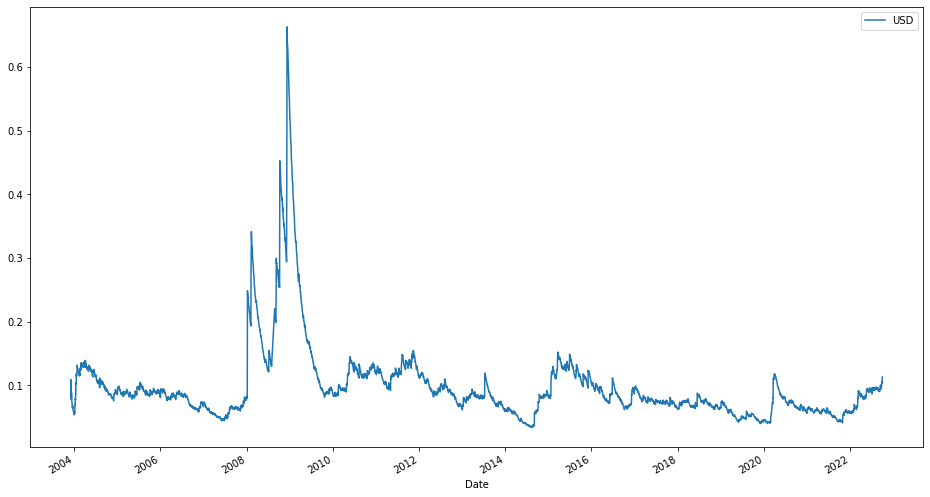

In [ ]:
features["EWVOL3M"]["USD"].plot(**plot_args);

In [ ]:
features.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M'])

In [ ]:
# Adding Returns Scaled by the Corresponding Volatility-Period estimate
periods = [1,3,5,10,21]
scaled_feature_names = ["SRET1D","SRET3D","SRET1W","SRET2W","SRET1M"]

for f, d in zip(scaled_feature_names, periods):
    features[f] = np.sqrt(252/d)*inverse_fx_rates.pct_change(d)/features["EWVOL3M"]

## 4 PMs-Based Features

### 4.1 Sharpe Ratios

In [ ]:
inverse_fx_rates.pct_change()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,-0.004362,-0.004722,-0.002378,-0.000229,-0.003295,-0.006543,0.000061,-0.004601,0.000799,-0.010254
2003-12-03,0.003893,-0.005648,-0.001091,0.000040,-0.003853,0.001371,0.005605,-0.002775,0.003990,-0.002805
2003-12-04,0.001767,-0.004422,0.001221,0.000107,-0.001567,0.003824,0.004231,0.002246,0.001228,0.003479
2003-12-05,-0.007859,-0.002960,0.003612,-0.000013,-0.001707,0.000229,0.000161,-0.008746,0.002002,-0.008698
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,-0.001645,0.007587,0.008827,-0.000054,-0.026418,0.007180,-0.002558,-0.002674,-0.005027,0.015648
2022-09-27,-0.002395,-0.002964,-0.003184,0.000039,0.004355,-0.000014,-0.011717,-0.006859,0.004433,0.006880
2022-09-28,-0.003045,0.001868,0.003332,-0.000039,-0.001420,0.001225,0.001547,-0.003093,-0.000744,0.002868


In [ ]:
# Thus, let us include 1M, 3M, 6M Sharpes as predictors
win = [21, 63, 126]
isharpe_names = ["ISR1M", "ISR3M", "ISR6M"]

for w, name in zip(win, isharpe_names):
    features[name] = inverse_fx_rates.pct_change().rolling(window=w).apply(pms.israelsen_sharpe_ratio)*np.sqrt(w/252)

<AxesSubplot:xlabel='Date'>

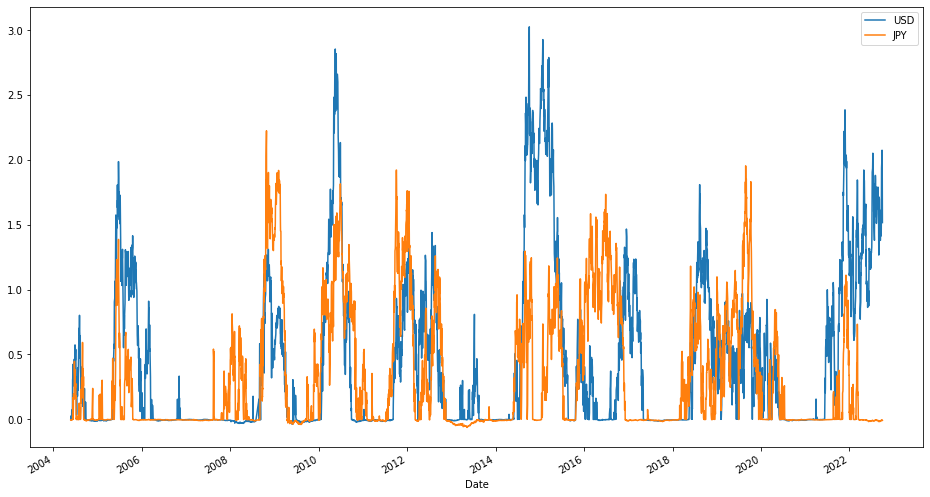

In [ ]:
features["ISR6M"][["USD","JPY"]].plot(**plot_args)

### 4.2 Skewness-Kurtosis Ratios

In [ ]:
# Thus, let us include 1M, 3M, 6M Sharpes as predictors
wins = [21, 63, 126]
names = ["SKR1M", "SKR3M", "SKR6M"]

for w, name in zip(wins, names):
    features[name] = inverse_fx_rates.pct_change().rolling(window=w).apply(pms.leon_sk_ratio)

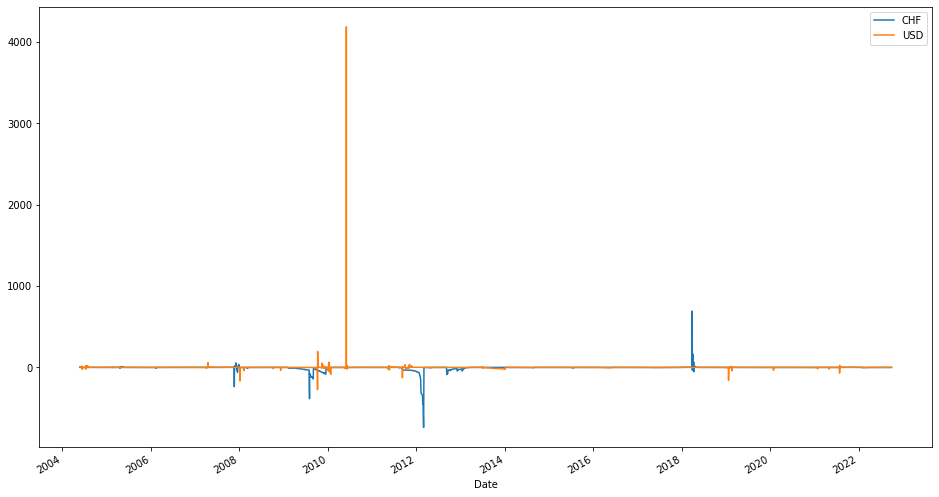

In [ ]:
features["SKR6M"][["CHF","USD"]].plot(**plot_args);

In [ ]:
currencies = inverse_fx_rates.columns.tolist()

In [ ]:
# Winsorizing SK Ratio
for feature in list(features.keys())[-3:]:
    features[feature] = features[feature].apply(winsorize, limits=(0.05,0.05))

<AxesSubplot:>

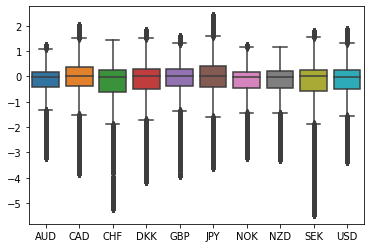

In [ ]:
sns.boxplot(
    data=features["SKR1M"][currencies],
)


<AxesSubplot:xlabel='Date'>

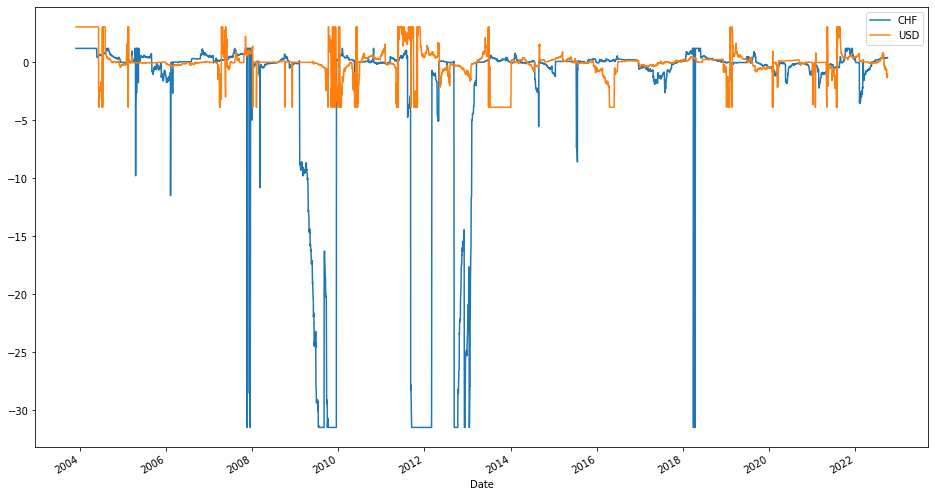

In [ ]:
features["SKR6M"][["CHF","USD"]].plot(**plot_args)

In [ ]:
# CheckPoint for Return-Based, Simple Ratio Features 
with open(PATH + "fx_data/FX_features_gcolab_pd135.pkl","wb+") as file:
    pickle.dump(features,file, protocol=pickle.HIGHEST_PROTOCOL)

### 4.3 PMs Based on Quantiles

In [ ]:
# Data preparation
with open(PATH + "fx_data/FX_features_gcolab_pd135.pkl","rb") as file:
    features = pickle.load(file)

In [ ]:
inverse_fx_rates = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col = "Date",
    parse_dates = ["Date"]
)

In [ ]:
features.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M'])

#### 4.3.1 VaR Ratio (Caporin-Lisi)

In [ ]:
from modules import performance_measures_helper as pms

In [ ]:
# Caporin-Lisi VaR Ratio
confidence_levels = [0.99, 0.95, 0.90, 0.80]
sample_periods = [21, 63, 126]

names = ["VARR1M","VARR3M", "VARR6M"]

for period, name in zip(sample_periods, names):
    for conf in confidence_levels:
        converted_conf = f"{int(100*conf):2}"
        print(f"Confidence Level "+converted_conf)        
        features[name+converted_conf] = inverse_fx_rates.pct_change().rolling(window=period).apply(
            pms.var_ratio,                                  
            kwargs={'quant': conf}
        )

Confidence Level 99
Confidence Level 95
Confidence Level 90
Confidence Level 80
Confidence Level 99
Confidence Level 95
Confidence Level 90
Confidence Level 80
Confidence Level 99
Confidence Level 95
Confidence Level 90
Confidence Level 80


In [ ]:
features.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80', 'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80'])

#### 4.3.2 Rachev Ratio (Conditional VaR)

In [ ]:
confidence_levels = [0.99, 0.95, 0.90, 0.80]
sample_periods = [21, 63, 126]

names = ["RACHEV1M","RACHEV3M", "RACHEV6M"]

for period, name in zip(sample_periods, names):
    for conf in confidence_levels:
        converted_conf = f"{int(100*conf):2}"
        print(f"Confidence Level "+converted_conf)
        features[name+converted_conf] = inverse_fx_rates.pct_change().rolling(window=period).apply(
            pms.rachev_ratio,                                  
            kwargs={'alpha': conf}
        ).abs()

Confidence Level 99
Confidence Level 95
Confidence Level 90
Confidence Level 80
Confidence Level 99
Confidence Level 95
Confidence Level 90
Confidence Level 80
Confidence Level 99
Confidence Level 95
Confidence Level 90
Confidence Level 80


[]

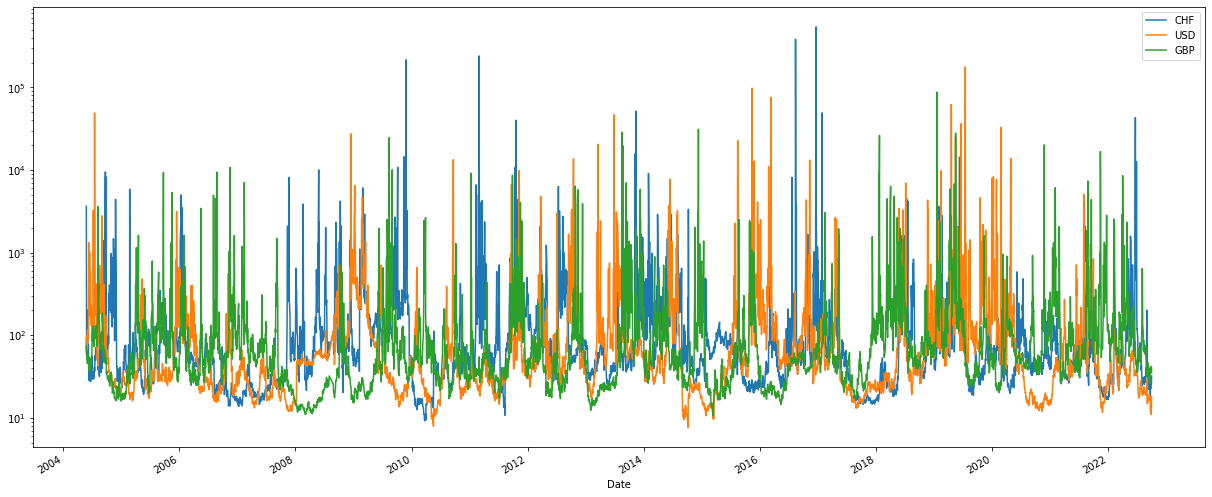

In [ ]:
features["RACHEV6M99"][["CHF","USD","GBP"]].plot(figsize=(21,9))
plt.semilogy()

[]

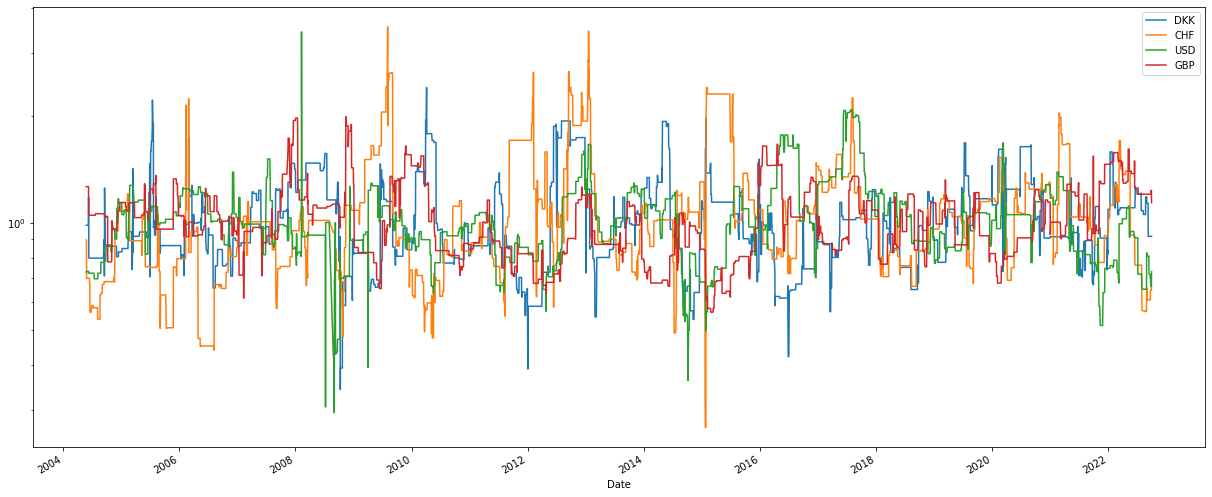

In [ ]:
features["VARR6M99"][["DKK","CHF","USD","GBP"]].plot(figsize=(21,9))
plt.semilogy()

In [ ]:
with open(PATH + "fx_data/FX_features_pd135_quantilePMs.pkl","wb+") as handle:
  pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 4.4 PMs based on LPMs

#### 4.4.1 Sortino Ratio

In [4]:
with open(PATH + "fx_data/FX_features_pd135_quantilePMs.pkl","rb+") as file:
  features = pickle.load(file)

In [8]:
inverse_fx_rates = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [9]:
sample_periods = [21, 63, 126]

names = ["SORTINO1M","SORTINO3M", "SORTINO6M"]

for period, name in zip(sample_periods, names):
  features[name] = inverse_fx_rates.pct_change().rolling(window=period).apply(
      pms.leon_sortino_ratio
  )

#### 4.4.2 Omega Ratio

In [10]:
names = ["OMEGA1M","OMEGA3M", "OMEGA6M"]

for period, name in zip(sample_periods, names):
  features[name] = inverse_fx_rates.pct_change().rolling(window=period).apply(
      pms.omega_ratio
  )

In [12]:
len(features.keys())

46

In [13]:
with open(PATH + "fx_data/FX_features_pd135_allPMs.pkl","wb+") as handle:
  pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 5 Compiling All Features

In [16]:
features[f]

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.996316,1.233726,1.378513,1.036287,0.754291,0.929020,0.855858,0.832008,0.790286,1.581658
2022-09-27,0.982682,1.215647,1.358799,1.033172,0.774841,0.939921,0.813501,0.816741,0.789716,1.601420
2022-09-28,0.928355,1.182193,1.345788,1.017155,0.742521,0.930688,0.781534,0.771504,0.784478,1.585821


In [17]:
lst_features = []

for f in features:
    feature = pd.melt(
        features[f].dropna(how="all"),
        var_name="symbols",
        value_name=f,
        ignore_index=False
    ).sort_values(by=["Date","symbols"])

    feature.reset_index(inplace=True)
    lst_features.append(feature)

In [18]:
lst_features[0]

,Date,symbols,MOM1W
0,2003-12-08,AUD,-0.003940
1,2003-12-08,CAD,-0.015777
2,2003-12-08,CHF,0.002648
3,2003-12-08,DKK,-0.000323
4,2003-12-08,GBP,-0.012631
...,...,...,...
48755,2022-09-30,JPY,-0.013828
48756,2022-09-30,NOK,-0.025115
48757,2022-09-30,NZD,-0.017141
48758,2022-09-30,SEK,-0.005453


In [19]:
#Allin 
from functools import reduce

features_merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["Date","symbols"],
        how="inner"),
        lst_features
  )

features_merged

,Date,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
0,2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
1,2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2,2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
3,2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
4,2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47545,2022-09-30,JPY,-0.013828,0.008650,-0.015004,-0.001733,0.116713,-1.713078,-1.636785,-0.841096,...,29.713701,11.730133,6.684602,3.437627,-0.017319,-0.000051,-8.237297e-03,0.791138,0.999108,0.880002
47546,2022-09-30,NOK,-0.025115,-0.030699,-0.047832,-0.024027,0.105945,-1.567972,-0.953833,-1.682903,...,21.663397,11.287347,6.736532,3.376912,-0.053072,-0.006932,-1.418737e-02,0.414838,0.867722,0.764384
47547,2022-09-30,NZD,-0.017141,-0.020903,-0.040241,-0.019437,0.085561,-1.530522,-0.824816,-1.422254,...,19.264163,10.789876,6.634187,3.452138,-0.036007,-0.005034,-1.143417e-02,0.349518,0.878612,0.754133
47548,2022-09-30,SEK,-0.005453,-0.019867,-0.020857,-0.015266,0.059063,-1.214404,-0.751035,-0.655429,...,25.331388,12.140380,7.345273,3.711804,-0.011847,-0.002648,-5.999875e-03,0.484508,0.857934,0.764439


In [21]:
features_merged.to_csv(
    PATH + "fx_data/20220930_FX_features.csv",
    index = False
)

## 6 Adding More Target Candidates (lagged ISR)

### 6.1 Quantized Format (Classifiers, LETOR)

In [25]:
features["ISR1M"]

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,-0.009567,-0.005167,0.387525,0.636078,-0.023110,-0.008446,-0.023586,-0.013558,-0.006750,0.876819
2022-09-27,-0.006666,-0.004190,0.329070,0.603238,-0.018811,-0.004843,-0.024583,-0.010460,-0.005800,0.973111
2022-09-28,-0.007101,-0.003002,0.704217,0.559852,-0.017418,-0.000087,-0.023743,-0.011234,-0.004025,1.335994


In [37]:
lagged_isr_score = features["ISR6M"].rank(axis=1).shift(-1)

In [45]:
buy_currency_signal = (lagged_isr_score==10).shift(1)

[]

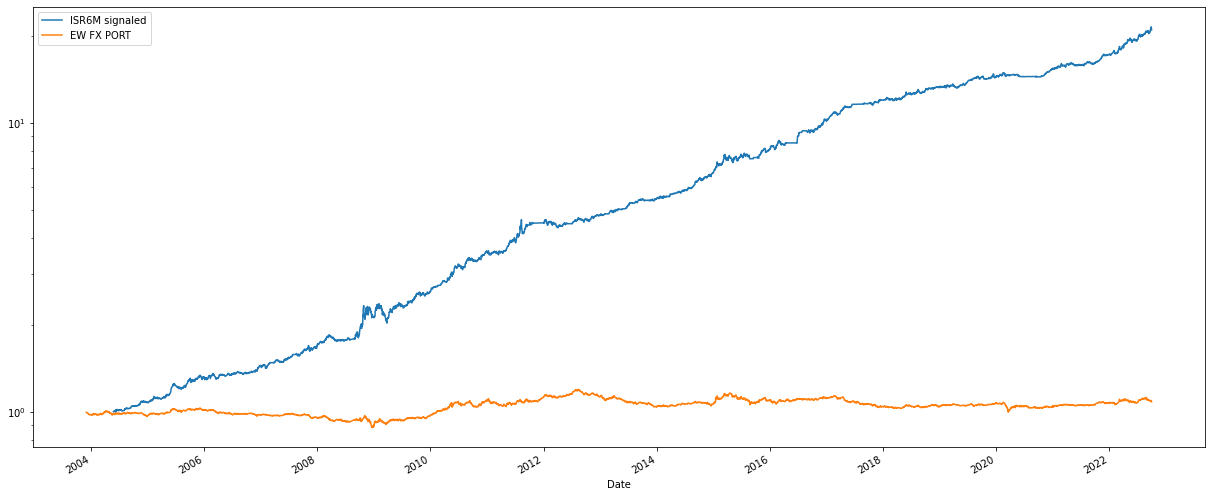

In [46]:
(1+inverse_fx_rates.pct_change()[buy_currency_signal].mean(axis=1,skipna=True)).cumprod().rename("ISR6M signaled").plot(
    figsize=(21,9), 
    legend=True
)
(1+inverse_fx_rates.pct_change().mean(axis=1,skipna=True)).cumprod().rename("EW FX PORT").plot(legend=True)
plt.semilogy()

<AxesSubplot:xlabel='Date'>

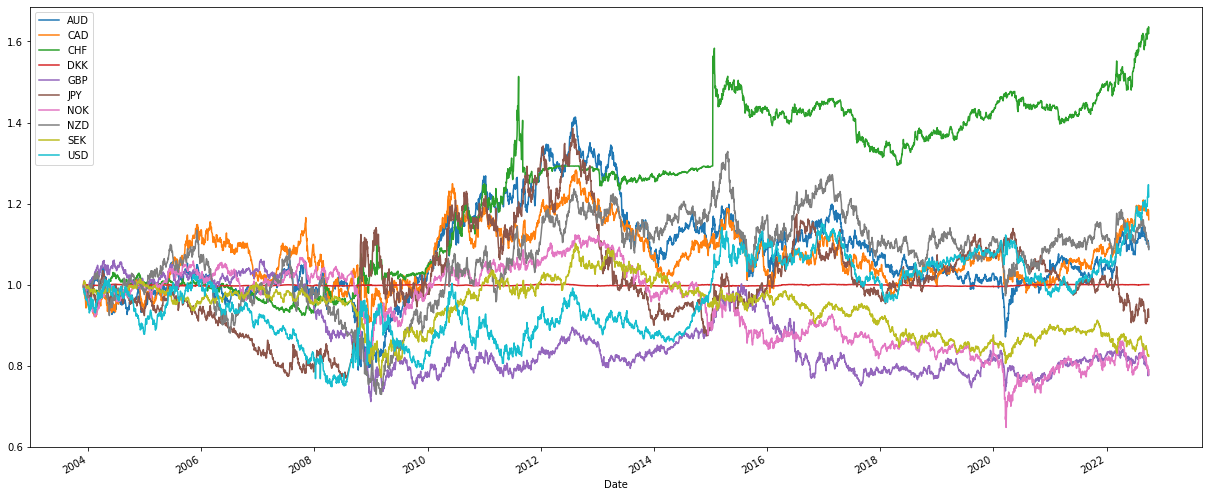

In [48]:
(1+inverse_fx_rates.pct_change()).cumprod().plot(figsize=(21,9),legend=True)

In [50]:
isr_features = ["ISR1M", "ISR3M", "ISR6M"]

lst_targets = []

for f in isr_features:
    feature = pd.melt(
        features[f].rank(axis=1).shift(-1).dropna(how="all"),
        var_name="symbols",
        value_name=f,
        ignore_index=False
    ).sort_values(by=["Date","symbols"])

    feature.reset_index(inplace=True)
    lst_targets.append(feature)


In [52]:
lst_targets[-1]

,Date,symbols,ISR6M
0,2004-05-24,AUD,3.0
1,2004-05-24,CAD,1.0
2,2004-05-24,CHF,9.0
3,2004-05-24,DKK,8.0
4,2004-05-24,GBP,10.0
...,...,...,...
47545,2022-09-29,JPY,3.0
47546,2022-09-29,NOK,1.0
47547,2022-09-29,NZD,2.0
47548,2022-09-29,SEK,5.0


In [53]:
isr_targets_merged = reduce(
    lambda left, right: pd.merge(
        left, 
        right,
        on = ["Date","symbols"],
        how="inner"
    ),
    lst_targets
)

In [54]:
isr_targets_merged

,Date,symbols,ISR1M,ISR3M,ISR6M
0,2004-05-24,AUD,1.0,2.0,3.0
1,2004-05-24,CAD,4.0,5.0,1.0
2,2004-05-24,CHF,10.0,9.0,9.0
3,2004-05-24,DKK,9.0,8.0,8.0
4,2004-05-24,GBP,6.0,3.0,10.0
...,...,...,...,...,...
47545,2022-09-29,JPY,5.0,6.0,3.0
47546,2022-09-29,NOK,1.0,1.0,1.0
47547,2022-09-29,NZD,2.0,3.0,2.0
47548,2022-09-29,SEK,7.0,4.0,5.0


In [55]:
isr_targets_merged = isr_targets_merged.astype({
    "ISR1M": int,
    "ISR3M": int,
    "ISR6M": int
    }
)

In [56]:
isr_targets_merged

,Date,symbols,ISR1M,ISR3M,ISR6M
0,2004-05-24,AUD,1,2,3
1,2004-05-24,CAD,4,5,1
2,2004-05-24,CHF,10,9,9
3,2004-05-24,DKK,9,8,8
4,2004-05-24,GBP,6,3,10
...,...,...,...,...,...
47545,2022-09-29,JPY,5,6,3
47546,2022-09-29,NOK,1,1,1
47547,2022-09-29,NZD,2,3,2
47548,2022-09-29,SEK,7,4,5


In [57]:
return_targets = pd.read_csv(
    PATH+"fx_data/FX_quantized_returns.csv",
    index_col="Date",
    parse_dates=["Date"]
)

return_targets

,symbols,rank
Date,,
2003-12-01,AUD,5
2003-12-01,CAD,3
2003-12-01,CHF,7
2003-12-01,DKK,8
2003-12-01,GBP,6
...,...,...
2022-09-29,JPY,2
2022-09-29,NOK,5
2022-09-29,NZD,7


In [60]:
return_targets.reset_index(inplace=True)

In [63]:
targets = pd.merge(
    return_targets,
    isr_targets_merged,
    how="inner",
    on=["Date","symbols"]
)

In [66]:
targets.rename(columns={
    "rank": "RET1DAH"
}, inplace=True)

In [67]:
targets

,Date,symbols,RET1DAH,ISR1M,ISR3M,ISR6M
0,2004-05-24,AUD,10,1,2,3
1,2004-05-24,CAD,1,4,5,1
2,2004-05-24,CHF,3,10,9,9
3,2004-05-24,DKK,5,9,8,8
4,2004-05-24,GBP,7,6,3,10
...,...,...,...,...,...,...
47545,2022-09-29,JPY,2,5,6,3
47546,2022-09-29,NOK,5,1,1,1
47547,2022-09-29,NZD,7,2,3,2
47548,2022-09-29,SEK,8,7,4,5


In [68]:
targets.to_csv(
    PATH + "fx_data/FX_quantized_targets.csv",
    index=False
)

### 6.2 Raw Format (Regress Then Rank)

In [71]:
raw_returns = inverse_fx_rates.pct_change()
raw_returns = raw_returns.shift(-1)

In [80]:
lagged_raw_rets = pd.melt(
    raw_returns,
    var_name="symbols",
    value_name="RAWRET1DAH",
    ignore_index=False
).sort_values(by=["Date","symbols"])

In [73]:
isr_features = ["ISR1M", "ISR3M", "ISR6M"]

lst_raw_targets = []

for f in isr_features:
    feature = pd.melt(
        features[f].shift(-1).dropna(how="all"),
        var_name="symbols",
        value_name="RAW"+f,
        ignore_index=False
    ).sort_values(by=["Date","symbols"])

    feature.reset_index(inplace=True)
    lst_raw_targets.append(feature)

In [75]:
lst_raw_targets[-1]

,Date,symbols,RAWISR6M
0,2004-05-24,AUD,-5.465233e-03
1,2004-05-24,CAD,-8.352494e-03
2,2004-05-24,CHF,3.521791e-01
3,2004-05-24,DKK,-1.622340e-07
4,2004-05-24,GBP,8.528283e-01
...,...,...,...
47545,2022-09-29,JPY,-8.212613e-03
47546,2022-09-29,NOK,-1.281935e-02
47547,2022-09-29,NZD,-1.020604e-02
47548,2022-09-29,SEK,-5.239502e-03


In [76]:
raw_targets = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        how="inner",
        on=["Date","symbols"]
    ),
    lst_raw_targets
)

In [77]:
raw_targets

,Date,symbols,RAWISR1M,RAWISR3M,RAWISR6M
0,2004-05-24,AUD,-0.024171,-0.014410,-5.465233e-03
1,2004-05-24,CAD,-0.015079,0.162377,-8.352494e-03
2,2004-05-24,CHF,0.745905,1.209960,3.521791e-01
3,2004-05-24,DKK,0.147710,0.991761,-1.622340e-07
4,2004-05-24,GBP,-0.001824,0.031751,8.528283e-01
...,...,...,...,...,...
47545,2022-09-29,JPY,-0.006250,-0.000036,-8.212613e-03
47546,2022-09-29,NOK,-0.017288,-0.004702,-1.281935e-02
47547,2022-09-29,NZD,-0.010319,-0.003284,-1.020604e-02
47548,2022-09-29,SEK,-0.003898,-0.001773,-5.239502e-03


In [78]:
raw_returns

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,-0.004362,-0.004722,-0.002378,-0.000229,-0.003295,-0.006543,0.000061,-0.004601,0.000799,-0.010254
2003-12-02,0.003893,-0.005648,-0.001091,0.000040,-0.003853,0.001371,0.005605,-0.002775,0.003990,-0.002805
2003-12-03,0.001767,-0.004422,0.001221,0.000107,-0.001567,0.003824,0.004231,0.002246,0.001228,0.003479
2003-12-04,-0.007859,-0.002960,0.003612,-0.000013,-0.001707,0.000229,0.000161,-0.008746,0.002002,-0.008698
2003-12-05,0.002667,0.001893,0.001292,-0.000228,-0.002271,-0.004038,-0.004729,0.000371,0.000459,-0.002706
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,-0.002395,-0.002964,-0.003184,0.000039,0.004355,-0.000014,-0.011717,-0.006859,0.004433,0.006880
2022-09-27,-0.003045,0.001868,0.003332,-0.000039,-0.001420,0.001225,0.001547,-0.003093,-0.000744,0.002868
2022-09-28,-0.000851,-0.004603,0.002624,-0.000019,-0.001529,-0.009567,-0.002111,0.003658,0.000421,-0.011535


In [81]:
lagged_raw_rets.reset_index(inplace=True)

In [83]:
lagged_raw_rets.dropna(how="all", inplace=True)

In [85]:
raw_targets = pd.merge(
    lagged_raw_rets,
    raw_targets,
    how="inner",
    on=["Date","symbols"]
).sort_values(by=["Date","symbols"])

In [86]:
raw_targets

,Date,symbols,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
0,2004-05-24,AUD,0.006140,-0.024171,-0.014410,-5.465233e-03
1,2004-05-24,CAD,-0.009400,-0.015079,0.162377,-8.352494e-03
2,2004-05-24,CHF,-0.002923,0.745905,1.209960,3.521791e-01
3,2004-05-24,DKK,-0.000094,0.147710,0.991761,-1.622340e-07
4,2004-05-24,GBP,0.002996,-0.001824,0.031751,8.528283e-01
...,...,...,...,...,...,...
47545,2022-09-29,JPY,-0.012595,-0.006250,-0.000036,-8.212613e-03
47546,2022-09-29,NOK,-0.010465,-0.017288,-0.004702,-1.281935e-02
47547,2022-09-29,NZD,-0.008249,-0.010319,-0.003284,-1.020604e-02
47548,2022-09-29,SEK,-0.004518,-0.003898,-0.001773,-5.239502e-03


In [87]:
raw_targets.to_csv(
    PATH + "fx_data/FX_raw_targets.csv",
    index=False
)